#### Excle表: 分类 ADMET、预测 ERα_activity、选变量 Molecular_Descriptor

### 第一问

预处理

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt#导入作图库
plt.rcParams['font.sans-serif']=['SimHei']#用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号
plt.figure(figsize=(7,5))#创建图像区域，制定比例
import seaborn as sns

<Figure size 504x360 with 0 Axes>

In [3]:
dataFirst1=pd.read_excel("Molecular_Descriptor.xlsx") #导入分子描述符的training数据集

In [4]:
dataSecond1=pd.read_excel("ERα_activity.xlsx")  #导入pIC50的training数据集

In [5]:
Y=dataSecond1['pIC50']

In [6]:
#查找表格中的全0列
names=[]
for i in range(1,dataFirst1.shape[1]):
    x=sum(dataFirst1.iloc[:,i])
    if x==0:
        names.append(dataFirst1.columns[i])

In [7]:
#删除表格中的全0列
dataFirst1=dataFirst1.drop(names,axis=1)
dataFirst1.shape

(1974, 505)

模型重要性指标选择

In [8]:
from sklearn.ensemble import RandomForestRegressor

In [9]:
#建立随机森林模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestRegressor(n_estimators=100,random_state=123)
model.fit(dataFirst1.iloc[:,1:],Y)

RandomForestRegressor(random_state=123)

In [11]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) MDEC-23                        0.212783
 2) LipoaffinityIndex              0.039312
 3) C1SP2                          0.037153
 4) maxHsOH                        0.030298
 5) maxssO                         0.027357
 6) minsssN                        0.027197
 7) minHsOH                        0.022560
 8) BCUTc-1l                       0.019245
 9) minsOH                         0.018107
10) minHBint5                      0.017614
11) nC                             0.017453
12) MLFER_A                        0.016570
13) nHBAcc                         0.016507
14) SHsOH                          0.013051
15) VC-5                           0.011800
16) ATSc3                          0.011364
17) TopoPSA                        0.009954
18) SHBint10                       0.009109
19) MDEO-12                        0.008018
20) ndssC                          0.007019
21) XLogP                          0.006726
22) MDEC-33                        0.006650
23) ETA_Shape_Y                 

spearman相关系数分析

In [12]:
dataFirst2=dataFirst1.iloc[:,indices[0:50]+1]

In [13]:
result1=dataFirst2.corr("spearman")

<AxesSubplot:>

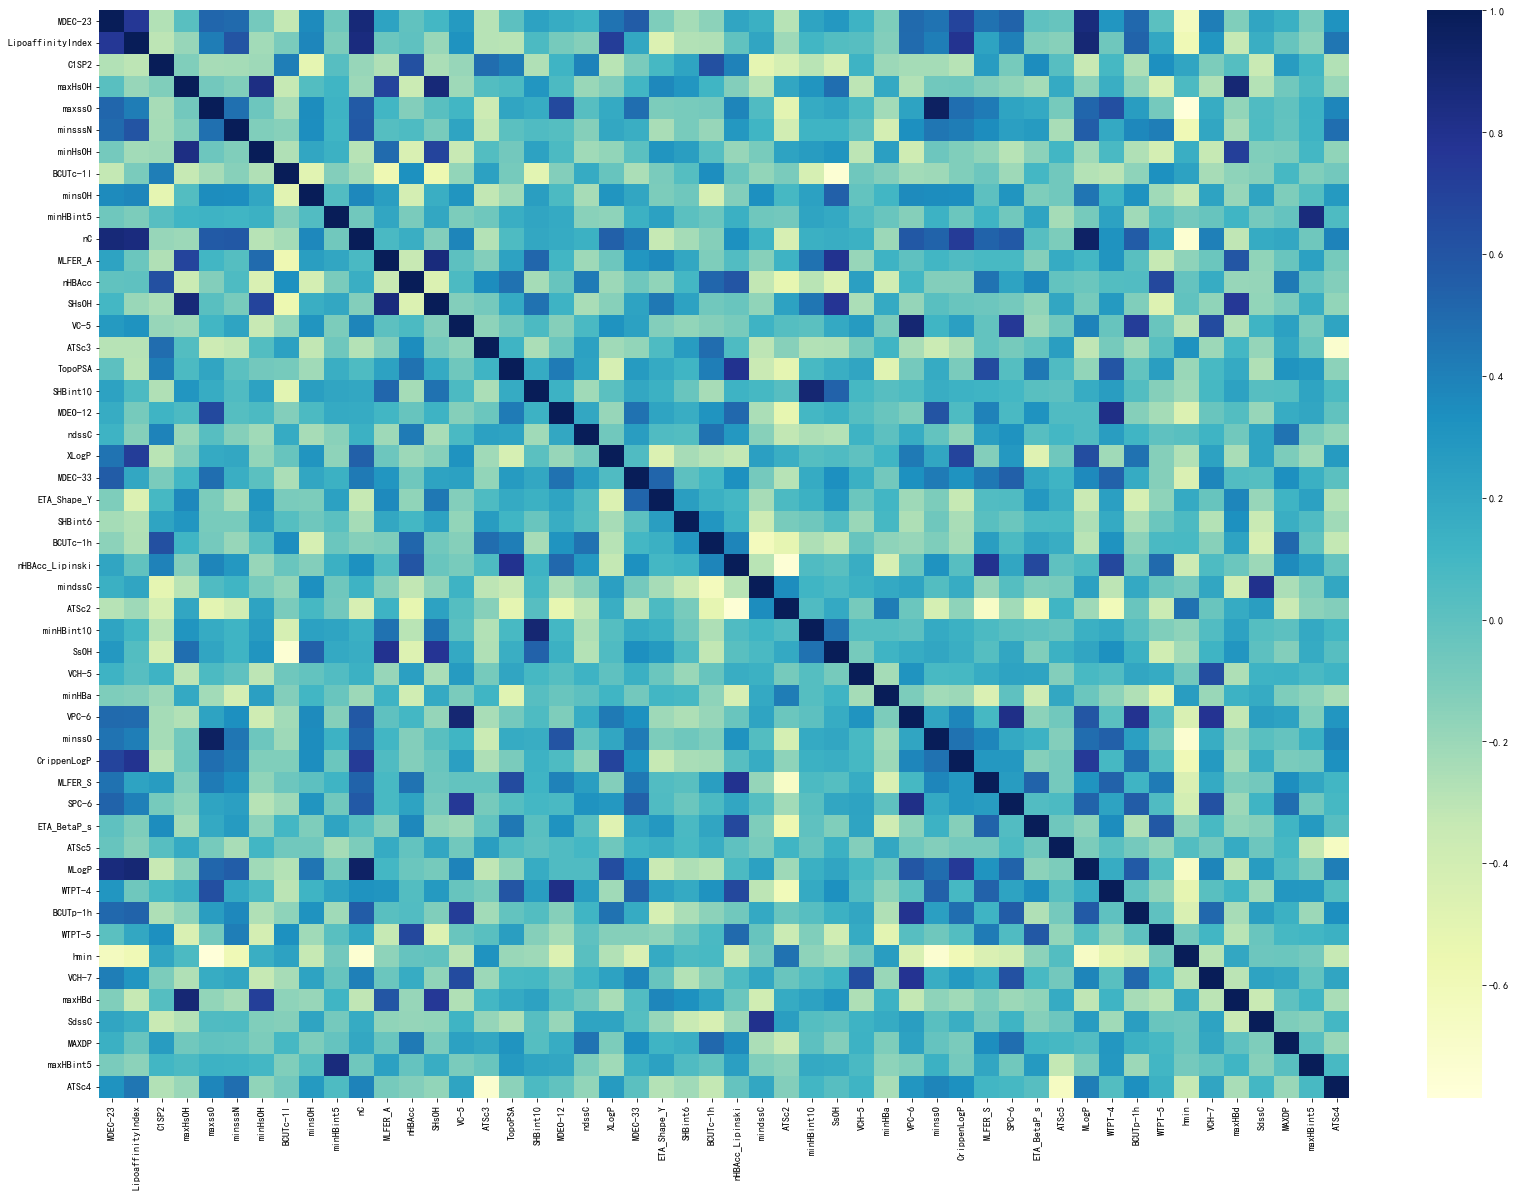

In [14]:
plt.figure(figsize=(28,20))
sns.heatmap(result1,cmap="YlGnBu") #颜色越淡，相关系数越小

In [15]:
#删除自相关系数高的变量
dataFirst3=dataFirst2.drop(['LipoaffinityIndex','nC','CrippenLogP','MLogP','hmin','minsssN','nHBAcc','BCUTc-1h',
'minHsOH','MLFER_A','SHsOH','maxHBd','MDEO-12','minssO','WTPT-4','maxHBint5','WTPT-5','VPC-6','BCUTp-1h',
'VCH-7','MLFER_S','minssO','ATSc2','SPC-6'],axis=1)

In [16]:
#删除自相关系数高的变量
dataFirst4=dataFirst3.drop(['ETA_BetaP_s','nHBAcc_Lipinski','SsOH','minHBint10','SdssC','MAXDP'],axis=1)
result=dataFirst4.corr("spearman")

相关系数热力图

<AxesSubplot:>

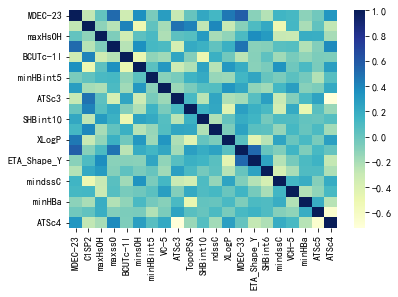

In [17]:
sns.heatmap(result,cmap="YlGnBu") #颜色越淡，相关系数越小

### 第二问

回归模型 评测标准:MSE、MAPE

In [18]:
#取前17个变量
data=dataFirst4.iloc[:,0:17]

In [19]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集
from sklearn import metrics

随机森林

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [45]:
model = RandomForestRegressor(random_state=100)
param = {'n_estimators':range(100, 110),
         'min_samples_leaf':np.arange(1, 11, 1),
         'max_depth':np.arange(1, 20, 1)
        }
grid_search = GridSearchCV(model, param_grid = param, cv = 5)
grid_search.fit(X_train,Y_train)
# print(grid_search.best_params_)

In [21]:
model = RandomForestRegressor(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)
Y_pred=model.predict(X_test)

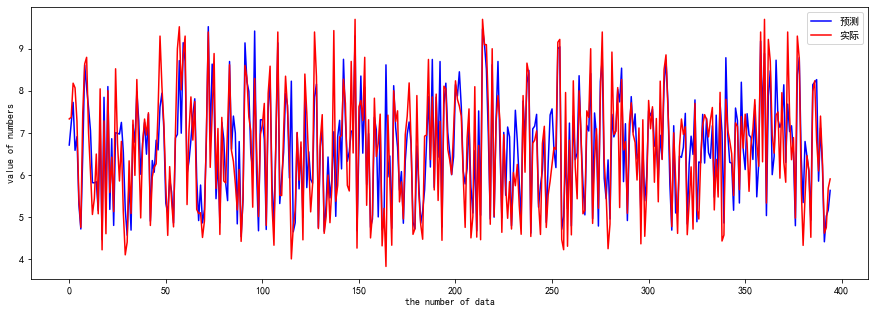

In [22]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="预测")
plt.plot(range(len(Y_pred)),Y_test,'r',label="实际")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [23]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:0.782
平均绝对百分比误差MAPE:8.931%


XGBoost

In [24]:
import xgboost as xgb

In [55]:
model = xgb.XGBRegressor(random_state=100)
param = {'max_depth':[3,5,7],
         'min_child_weight':[1,3,6],
         'n_estimators':[100,200,300],
         'learning_rate':[0.01,0.05,0.1]
        }
grid_search = GridSearchCV(model, param_grid = param, cv = 5)
grid_search.fit(X_train,Y_train)
print(grid_search.best_params_)

{'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 6, 'n_estimators': 300}


In [25]:
# 创建xgboost
model=xgb.XGBRegressor(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)

# 拟合构造xgboost
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
Y_pred=model.predict(X_test)

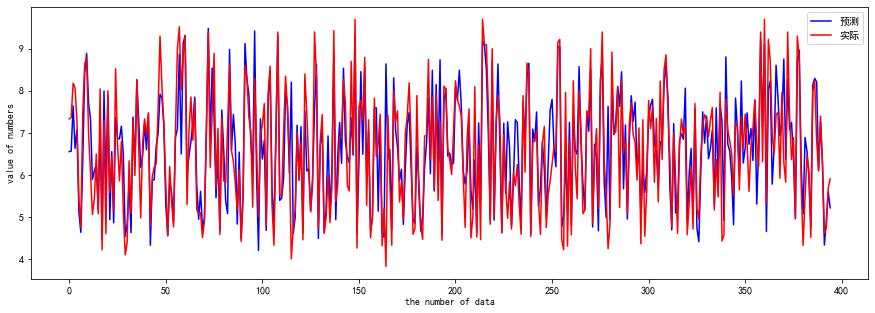

In [26]:
plt.figure(figsize=(15,5))#预测曲线与真实曲线做对比
plt.plot(range(len(Y_pred)),Y_pred,'b',label="预测")
plt.plot(range(len(Y_pred)),Y_test,'r',label="实际")
plt.legend(loc="upper right") #显示图中的标签
plt.xlabel("the number of data")
plt.ylabel('value of numbers')
plt.show()

In [27]:
#准确率
print("均方根误差RMSE:{:.3f}".format(np.sqrt(metrics.mean_squared_error(Y_test, Y_pred))))
MAPE=np.mean(np.abs((Y_pred - Y_test) / Y_test)) * 100
print("平均绝对百分比误差MAPE:{:.3f}%".format(MAPE))

均方根误差RMSE:0.777
平均绝对百分比误差MAPE:8.851%


#### 预测test中的值(选随机森林)

In [28]:
model = RandomForestRegressor(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

RandomForestRegressor(max_depth=16, min_samples_leaf=2, n_estimators=108,
                      random_state=100)

In [29]:
data1=pd.read_excel("Molecular_Descriptor.xlsx",sheet_name=1)

In [30]:
#20个筛选变量的列名
names=['MDEC-23','C1SP2','maxHsOH','maxssO','BCUTc-1l','minsOH','minHBint5','VC-5',
'ATSc3','TopoPSA','SHBint10','ndssC','XLogP','MDEC-33','ETA_Shape_Y','SHBint6','mindssC',
'VCH-5','minHBa','ATSc5']                                             

In [31]:
data1=data1.loc[:,names]

In [32]:
data2=data1.iloc[:,0:17] #取前17个变量

In [33]:
x_test=data2 #预测集中的自变量

In [34]:
# 预测 预测集中的因变量值
y_pred=model.predict(x_test)

### 第三问

#### 第一个

重要性指标筛选

In [35]:
from sklearn.ensemble import RandomForestClassifier

In [36]:
dataThird1=pd.read_excel("ADMET.xlsx")

In [37]:
Y1=dataThird1['Caco-2']

In [38]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(dataFirst1.iloc[:,1:],Y1)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, n_estimators=108,
                       random_state=100)

In [39]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) ETA_Eta_R_L                    0.034956
 2) ETA_Beta_s                     0.031176
 3) ETA_Eta_R                      0.026999
 4) WPATH                          0.025128
 5) WTPT-1                         0.024519
 6) nHeavyAtom                     0.024443
 7) MW                             0.024333
 8) SP-1                           0.023925
 9) MLFER_L                        0.021659
10) CrippenMR                      0.020506
11) ETA_Alpha                      0.017989
12) ECCEN                          0.017857
13) ETA_Beta                       0.016525
14) sumI                           0.014836
15) Kier1                          0.014354
16) VP-0                           0.014245
17) maxaaO                         0.013206
18) VABC                           0.011985
19) SaaO                           0.011323
20) Kier2                          0.011177
21) SP-2                           0.011058
22) AMR                            0.010846
23) VAdjMat                     

In [40]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5888153719897222

In [41]:
dataFirst5=dataFirst1.iloc[:,indices[0:50]+1]

In [42]:
data=dataFirst5

随机森林分类

In [43]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y1,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [44]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score,precision_recall_fscore_support

In [45]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

评价指标

In [46]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.898734
精确率Precision:0.923077
召回率Recall:0.915663
F1 score:0.9193548387096774
AUC:0.892763


XGBoost分类

In [47]:
import xgboost as xgb

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [48]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.886076
精确率Precision:0.908000
召回率Recall:0.911647
F1 score:0.9098196392785571
AUC:0.877056


预测test中的值(选随机森林)

In [49]:
data1=pd.read_excel("Molecular_Descriptor.xlsx",sheet_name=1)

In [50]:
x_test=data1[feat_labels[indices[0:50]]]  #测试集中的自变量

In [51]:
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)
# 预测测试集中的因变量值
y_pred=model.predict(x_test)

#### 第二个

In [52]:
Y2=dataThird1['CYP3A4']

In [53]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(dataFirst1.iloc[:,1:],Y2)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, n_estimators=108,
                       random_state=100)

In [54]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) VP-7                           0.037079
 2) Zagreb                         0.026913
 3) VP-3                           0.026652
 4) VP-2                           0.026359
 5) VP-5                           0.021995
 6) VP-4                           0.021982
 7) ETA_Eta_L                      0.021861
 8) SP-4                           0.021661
 9) ETA_Beta_s                     0.021617
10) ATSp2                          0.020543
11) SP-3                           0.020089
12) ETA_Eta_R                      0.019809
13) WTPT-1                         0.019724
14) VP-6                           0.018946
15) ETA_Eta_R_L                    0.017901
16) SP-7                           0.016451
17) VABC                           0.014173
18) VP-1                           0.013586
19) ATSp3                          0.013290
20) ATSp4                          0.012861
21) apol                           0.011987
22) SP-1                           0.011652
23) VP-0                        

In [55]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.6169591362709528

In [56]:
dataFirst6=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst6

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y2,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [58]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [59]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.921519
精确率Precision:0.872881
召回率Recall:0.865546
F1 score:0.869198312236287
AUC:0.905599


In [60]:
import xgboost as xgb

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [61]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.936709
精确率Precision:0.898305
召回率Recall:0.890756
F1 score:0.8945147679324895
AUC:0.923639


预测test中的值(选随机森林)

In [62]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
y_pred=model.predict(x_test)

#### 第三个

In [63]:
Y3=dataThird1['hERG']

In [64]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(dataFirst1.iloc[:,1:],Y3)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, n_estimators=108,
                       random_state=100)

In [65]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) VP-0                           0.035117
 2) CrippenMR                      0.033042
 3) Kier1                          0.029636
 4) SP-1                           0.024571
 5) ETA_Eta_R                      0.023642
 6) WPATH                          0.023616
 7) ETA_Eta_R_L                    0.022437
 8) Kier2                          0.019026
 9) nHeavyAtom                     0.018935
10) MLFER_L                        0.017653
11) ETA_Beta_s                     0.016437
12) ETA_Alpha                      0.015064
13) ECCEN                          0.014810
14) minsssN                        0.013440
15) AMR                            0.012734
16) bpol                           0.012273
17) VABC                           0.012004
18) VP-1                           0.011857
19) MW                             0.011025
20) Kier3                          0.010452
21) nBonds2                        0.009936
22) fragC                          0.009639
23) VP-2                        

In [66]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5640058378620574

In [67]:
dataFirst7=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst7

In [68]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y3,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [69]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [70]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.893671
精确率Precision:0.892857
召回率Recall:0.862069
F1 score:0.8771929824561403
AUC:0.890311


In [71]:
import xgboost as xgb

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [72]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.875949
精确率Precision:0.861272
召回率Recall:0.856322
F1 score:0.8587896253602305
AUC:0.873862


预测test中的值(选随机森林)

In [73]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
y_pred=model.predict(x_test)

#### 第四个

In [74]:
Y4=dataThird1['HOB']

In [75]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(dataFirst1.iloc[:,1:],Y4)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, n_estimators=108,
                       random_state=100)

In [76]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) BCUTc-1l                       0.042607
 2) maxsOH                         0.030092
 3) SsOH                           0.021309
 4) maxHsOH                        0.021002
 5) minsOH                         0.018852
 6) SHsOH                          0.017836
 7) minHsOH                        0.017459
 8) nHsOH                          0.016137
 9) MLFER_A                        0.012434
10) BCUTp-1l                       0.010219
11) hmin                           0.008027
12) SHBd                           0.007807
13) nsOH                           0.007329
14) maxHBd                         0.007030
15) VP-6                           0.006610
16) MDEN-22                        0.006179
17) VP-3                           0.006156
18) nHBAcc                         0.005943
19) minaasC                        0.005817
20) maxdO                          0.005677
21) ATSc3                          0.005648
22) mindO                          0.005577
23) SdO                         

In [77]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.413711036415215

In [78]:
dataFirst8=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst8

In [79]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y4,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [80]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [81]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.883544
精确率Precision:0.898734
召回率Recall:0.953020
F1 score:0.9250814332247557
AUC:0.811562


In [82]:
import xgboost as xgb

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [83]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{:3f}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.891139
精确率Precision:0.899687
召回率Recall:0.963087
F1 score:0.930308
AUC:0.816595


预测test中的值(选XGBoost)

In [84]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
y_pred=model.predict(x_test)

#### 第五个

In [85]:
Y5=dataThird1['MN']

In [86]:
#建立随机森林分类模型
feat_labels=dataFirst1.columns[1:]
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(dataFirst1.iloc[:,1:],Y5)

RandomForestClassifier(max_depth=16, min_samples_leaf=2, n_estimators=108,
                       random_state=100)

In [87]:
#变量重要性
importances=model.feature_importances_
indices = np.argsort(importances)[::-1]
for i in range(50):  # 打印前50个重要变量
    print("%2d) %-*s %f" % (i + 1, 30, feat_labels[indices[i]], importances[indices[i]]))

 1) WTPT-5                         0.035125
 2) WTPT-3                         0.028902
 3) ETA_BetaP_s                    0.024316
 4) ETA_Epsilon_4                  0.023523
 5) TopoPSA                        0.022995
 6) nHBAcc_Lipinski                0.021940
 7) ETA_Epsilon_1                  0.020748
 8) nN                             0.017431
 9) ETA_dEpsilon_A                 0.014655
10) ETA_BetaP                      0.013774
11) nHBAcc                         0.013700
12) nBondsD                        0.013101
13) minHBa                         0.011704
14) ETA_dEpsilon_C                 0.011194
15) MLFER_E                        0.010984
16) ETA_EtaP_L                     0.010945
17) ETA_EtaP_F_L                   0.010734
18) maxsCH3                        0.010298
19) MLFER_S                        0.010005
20) nHBAcc2                        0.009746
21) ETA_EtaP_F                     0.009551
22) maxHother                      0.009186
23) mindssC                     

In [88]:
sum(importances[indices[0:50]]) #筛选后前50个贡献度总和

0.5129764594450106

In [89]:
dataFirst9=dataFirst1.iloc[:,indices[0:50]+1]
data=dataFirst9

In [90]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(data,Y5,train_size=0.8,shuffle=True)#样本数据前80%做为训练集，后20%做为测试集

In [91]:
from sklearn.ensemble import RandomForestClassifier
model=RandomForestClassifier(n_estimators=108, min_samples_leaf=2, max_depth=16, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [92]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.967089
精确率Precision:0.977273
召回率Recall:0.886598
F1 score:0.9297297297297297
AUC:0.939943


In [93]:
import xgboost as xgb

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测验证集中的因变量值
Y_pred=model.predict(X_test)

In [94]:
print("准确率Accuracy:{:3f}".format(accuracy_score(Y_test,Y_pred)))
pre, rec, f1, sup = precision_recall_fscore_support(Y_test,Y_pred)
print("精确率Precision:{:3f}".format(pre[0]))
print("召回率Recall:{:3f}".format(rec[0]))
print("F1 score:{}".format(f1[0]))
# 计算auc
print("AUC:{:3f}".format(roc_auc_score(Y_test,Y_pred)))

准确率Accuracy:0.977215
精确率Precision:0.968085
召回率Recall:0.938144
F1 score:0.9528795811518325
AUC:0.964039


预测test中的值(选XGBoost)

In [95]:
x_test=data1[feat_labels[indices[0:50]]]  #预测集中的自变量

model=xgb.XGBClassifier(n_estimators=300, min_child_weight=6, max_depth=7, learning_rate=0.05, random_state=100)
model.fit(X_train,Y_train)

# 预测测试集中的因变量值
y_pred=model.predict(x_test)

### 第四问

In [96]:
dataResult=pd.read_excel("Molecular_Descriptor 筛选表.xls")

In [97]:
import matplotlib.mlab as mlab
from scipy.stats import norm

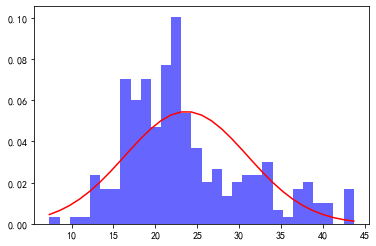

In [98]:
x=dataResult.iloc[:,1] #提取列变量 
mu =np.mean(x) #计算均值 
sigma =np.std(x) #计算标准差
n, bins, patches = plt.hist(x,bins=30,density=1,facecolor='blue',alpha=0.6)
y = norm.pdf(bins, mu, sigma) #拟合一条最佳正态分布曲线y 
plt.plot(bins, y, 'r') #绘制y的曲线 

（μ-2σ，μ+2σ）

In [99]:
for i in range(1,20):
    x=dataResult.iloc[:,i] #提取列变量 
    mu =np.mean(x) #计算均值 
    sigma =np.std(x) #计算标准差
    print("变量"+names[i]+"的(μ-2σ，μ+2σ）区间: ({},{})".format(round(mu-2*sigma,3),round(mu+2*sigma,3)))

变量C1SP2的(μ-2σ，μ+2σ）区间: (9.055,38.323)
变量maxHsOH的(μ-2σ，μ+2σ）区间: (3.208,13.421)
变量maxssO的(μ-2σ，μ+2σ）区间: (-0.817,1.524)
变量BCUTc-1l的(μ-2σ，μ+2σ）区间: (0.059,0.893)
变量minsOH的(μ-2σ，μ+2σ）区间: (13.393,36.006)
变量minHBint5的(μ-2σ，μ+2σ）区间: (-125.558,1158.737)
变量VC-5的(μ-2σ，μ+2σ）区间: (6.291,17.47)
变量ATSc3的(μ-2σ，μ+2σ）区间: (9.215,28.398)
变量TopoPSA的(μ-2σ，μ+2σ）区间: (2.006,9.657)
变量SHBint10的(μ-2σ，μ+2σ）区间: (4.257,11.435)
变量ndssC的(μ-2σ，μ+2σ）区间: (2.008,8.11)
变量XLogP的(μ-2σ，μ+2σ）区间: (0.578,4.899)
变量MDEC-33的(μ-2σ，μ+2σ）区间: (4.142,12.99)
变量ETA_Shape_Y的(μ-2σ，μ+2σ）区间: (-0.406,-0.305)
变量SHBint6的(μ-2σ，μ+2σ）区间: (-0.157,1.743)
变量mindssC的(μ-2σ，μ+2σ）区间: (0.015,1.621)
变量VCH-5的(μ-2σ，μ+2σ）区间: (-4.155,9.424)
变量minHBa的(μ-2σ，μ+2σ）区间: (0.871,22.519)
变量ATSc5的(μ-2σ，μ+2σ）区间: (0.55,0.655)
